# Preliminaries

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
dataset = pd.read_csv("/content/healthcare-dataset-stroke-data.csv")

print(dataset.shape)
dataset.head()

(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Preprocessing

### Cleaning data
Pada langkah ini dilakukan pembuangan kolom id dan pembuangan sample-sample dengan nilai `bmi` null dan/atau nilai `smoking_status` "Unknown".

In [ ]:
dataset = dataset.drop(columns=['id'])
dataset = dataset[dataset['bmi'].notna()]
dataset = dataset[dataset.smoking_status != "Unknown"]

In [ ]:
x = dataset.drop(columns=['stroke'])
y = dataset['stroke']

In [ ]:
y.value_counts()

0    3246
1     180
Name: stroke, dtype: int64

## Random oversampling
Pada langkah ini dilakukan upaya resampling untuk memitigasi pengaruh keadaan "under-represented" dari sample-sample dengan value `stroke` bernilai 1.



In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
resampler = RandomOverSampler(sampling_strategy={0: 3246, 1: 3246}, random_state=42)
x_resampled, y_resampled = resampler.fit_resample(x, y)

In [ ]:
y_resampled.value_counts()

1    3246
0    3246
Name: stroke, dtype: int64

## Shaping dataset
Untuk mengubah feature-feature yang bersifat "categorical", digunakan metode one-hot encoding.

In [ ]:
oneHotEncoding = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [0,4,5,6,9])], remainder='passthrough')
x_resampled = np.array(oneHotEncoding.fit_transform(x_resampled))
print(x_resampled)

[[  0.     1.     0.   ...   1.   228.69  36.6 ]
 [  0.     1.     0.   ...   1.   105.92  32.5 ]
 [  1.     0.     0.   ...   0.   171.23  34.4 ]
 ...
 [  0.     1.     0.   ...   0.   249.31  35.8 ]
 [  1.     0.     0.   ...   0.   205.35  42.2 ]
 [  0.     1.     0.   ...   1.   144.9   26.4 ]]


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size = 0.2, random_state=42)

In [ ]:
y_train_1 = to_categorical(y_train)
y_test_1 = to_categorical(y_test)
y_1 = to_categorical(y_resampled)

## Scaling input data

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# MLP training

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000, early_stopping=True, validation_fraction=0.15, verbose=True)

In [ ]:
mlp.fit(x_train_scaled, y_train_1)

Iteration 1, loss = 1.24523094
Validation score: 0.754814
Iteration 2, loss = 0.98956798
Validation score: 0.818999
Iteration 3, loss = 0.91287408
Validation score: 0.821566
Iteration 4, loss = 0.86859345
Validation score: 0.826701
Iteration 5, loss = 0.83795470
Validation score: 0.827985
Iteration 6, loss = 0.78872965
Validation score: 0.839538
Iteration 7, loss = 0.75631235
Validation score: 0.838254
Iteration 8, loss = 0.71260752
Validation score: 0.845956
Iteration 9, loss = 0.68454107
Validation score: 0.847240
Iteration 10, loss = 0.64954276
Validation score: 0.871630
Iteration 11, loss = 0.61088928
Validation score: 0.878049
Iteration 12, loss = 0.56840091
Validation score: 0.876765
Iteration 13, loss = 0.53474030
Validation score: 0.902439
Iteration 14, loss = 0.50691147
Validation score: 0.898588
Iteration 15, loss = 0.48089069
Validation score: 0.902439
Iteration 16, loss = 0.45118880
Validation score: 0.885751
Iteration 17, loss = 0.43009074
Validation score: 0.912709
Iterat

MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 100, 100),
              max_iter=1000, validation_fraction=0.15, verbose=True)

# MLP model evaluation

### Evaluasi model MLP dengan menggunakan data testing.

In [ ]:
y_pred = mlp.predict(x_test_scaled)

In [ ]:
accuracy_score(np.argmax(y_test_1, axis=1), np.argmax(y_pred, axis=1))

0.9576597382602001

In [ ]:
print(classification_report(np.argmax(y_test_1, axis=1), np.argmax(y_pred, axis=1), zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       664
           1       0.92      1.00      0.96       635

    accuracy                           0.96      1299
   macro avg       0.96      0.96      0.96      1299
weighted avg       0.96      0.96      0.96      1299



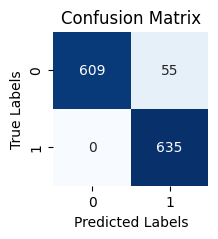

In [ ]:
cm = confusion_matrix(np.argmax(y_test_1, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()